In [50]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

import sympy as sp
from scipy.interpolate import LSQUnivariateSpline, BSpline, PPoly
from sklearn.model_selection import KFold

sys.path.append(os.path.dirname(os.getcwd()))

from lib.sampler import generate_reference_data
from lib.sympy_helper import wrap_as_function

In [51]:
df = generate_reference_data(1000)
x = df['diameter'].values
y = df['v_t'].values

In [ ]:
def build_optimal_spline(x, y, k_min: int = 3, k_max: int = 15, n_splits: int = 5):
    best_knot_count, best_knots, best_mse = None, None, np.inf

    for knot_count in range(k_min, min(k_max, len(x) - 2)):
        q = np.linspace(0, 1, knot_count + 2)[1:-1]
        knots = np.quantile(x, q)

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
        mse = 0.0
        for train_idx, val_idx in kf.split(x):
            xs_tr, ys_tr = x[train_idx], y[train_idx]
            xs_val, ys_val = x[val_idx], y[val_idx]

            try:
                model = LSQUnivariateSpline(xs_tr, ys_tr, knots, k=3)
                mse += np.mean((model(xs_val) - ys_val) ** 2)
            except (ValueError, np.linalg.LinAlgError):
                mse = np.inf
                break
        mse /= n_splits

        if mse < best_mse:
            best_knot_count, best_knots, best_mse = knot_count, knots, mse

    if best_knots is None:
        raise RuntimeError("Could not fit a spline with the provided settings.")

    return LSQUnivariateSpline(x, y, best_knots, k=3), best_knots


In [ ]:
def spline_to_sympy(spline):
    bspl  = BSpline.construct_fast(spline.get_knots(), spline.get_coeffs(), 3)
    ppoly = PPoly.from_spline(bspl) 
    x   = sp.symbols('x')
    deg = ppoly.c.shape[0] - 1

    pieces = []
    for i in range(ppoly.c.shape[1]):
        coeffs = ppoly.c[:, i]
        x0     = ppoly.x[i]
        poly = sum(coeffs[j] * (x - x0) ** (deg - j) for j in range(deg + 1))

        if i < ppoly.c.shape[1] - 1:
            cond = (x >= ppoly.x[i]) & (x < ppoly.x[i + 1])
        else:
            cond = True
        pieces.append((sp.expand(poly), cond))

    return sp.Piecewise(*pieces)


In [54]:
spline, knots = build_optimal_spline(x, y, k_min=0, k_max=20)
print(len(knots))

17


In [55]:
df['pred'] = spline(df['diameter'])
df['abs'] = np.abs(df['v_t'] - df['pred'])
df['rel'] = df['abs'] / df['v_t']
df['rel'].describe()

count    1.000000e+03
mean     8.270604e-04
std      1.037898e-03
min      6.149807e-08
25%      2.324236e-04
50%      4.230737e-04
75%      9.931048e-04
max      1.023700e-02
Name: rel, dtype: float64

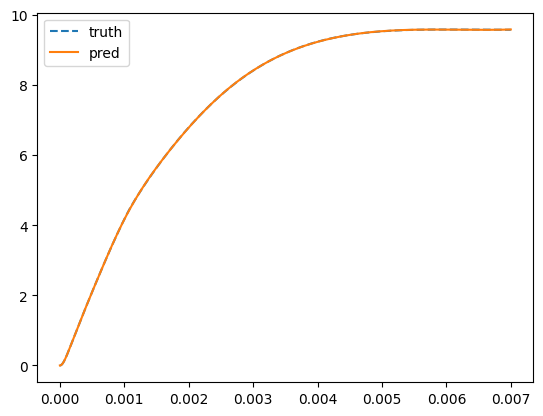

In [56]:
plt.plot(df['diameter'], df['v_t'], linestyle="dashed", label="truth")
plt.plot(df['diameter'], df['pred'], label="pred")

plt.legend()

In [57]:
df[df['pred'].diff() < 0][['diameter', 'pred']]

,diameter,pred
979,0.005863,9.572949
980,0.005915,9.572628
981,0.005968,9.572140
982,0.006021,9.571512
983,0.006075,9.570774
984,0.006129,9.569958
985,0.006183,9.569096
986,0.006238,9.568223
987,0.006294,9.567376
988,0.006350,9.566593


In [58]:
sym_expr = spline_to_sympy(spline)
code = sp.fcode(sym_expr, assign_to="res", source_format="free", standard=95)
func = wrap_as_function(code, name="ref", args=['x'])
print(func)

PURE ELEMENTAL FUNCTION ref(x) result(res)
    IMPLICIT NONE
    real(kind(0d0)), INTENT(IN) :: x
    real(kind(0d0)) :: res
    if (x >= 1.0d-6 .and. x < 1.63538805643937d-6) then
   res = 94291401597.654d0*x**3 + 240362.691476778d0*x**2 + &
      2.60396454105828d0*x + 1.90040474221925d-5
else if (x >= 1.63538805643937d-6 .and. x < 2.67444157919734d-6) then
   res = 94291401597.654d0*x**3 + 240362.691476776d0*x**2 + &
      2.60396454105831d0*x + 1.90040474221925d-5
else if (x >= 2.67444157919734d-6 .and. x < 4.37374981626418d-6) then
   res = 94291401597.654d0*x**3 + 240362.691476777d0*x**2 + &
      2.6039645410583d0*x + 1.90040474221925d-5
else if (x >= 4.37374981626418d-6 .and. x < 7.15263776053955d-6) then
   res = 94291401597.654d0*x**3 + 240362.69147678d0*x**2 + &
      2.60396454105828d0*x + 1.90040474221925d-5
else if (x >= 7.15263776053955d-6 .and. x < 1.16973383656236d-5) then
   res = -58349080068.3717d0*x**3 + 3515708.91033086d0*x**2 - &
      20.8234005027578d0*x + 7.48